In [1]:
# 📦 Predicting Uber Ride Cancellations 🚕

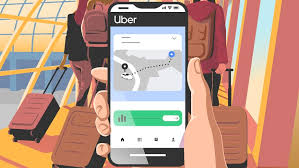


## Project Objective

#### Predicting Uber ride cancellations is essential for improving ride reliability and customer satisfaction. In this project, an Uber ride dataset was preprocessed by handling missing values and encoding categorical features. Several Machine Learning classification models were built using Scikit-learn (and XGBoost when available) to predict cancellation likelihood. Model performance was evaluated using accuracy, precision, recall, F1-score, and ROC-AUC to determine the most effective algorithm for identifying high-risk cancellations.

### Step 1: Import Required Modules

In [2]:
import warnings; warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, classification_report, confusion_matrix, RocCurveDisplay)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

try:
    from xgboost import XGBClassifier
    _HAS_XGB = True
except Exception:
    _HAS_XGB = False

import joblib

print('All modules imported. XGBoost available:', _HAS_XGB)



All modules imported. XGBoost available: True


In [3]:
#pip install joblib

In [4]:
#!pip install ipywidgets

In [8]:
import ipywidgets as widgets
from IPython.display import display, clear_output

### Step 2: Loading Data

In [9]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("yashdevladdha/uber-ride-analytics-dashboard")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\ashme\.cache\kagglehub\datasets\yashdevladdha\uber-ride-analytics-dashboard\versions\2


In [10]:
df = pd.read_csv("ncr_ride_bookings.csv")
print("Raw shape:", df.shape)
df.head()

Raw shape: (150000, 21)


,Date,Time,Booking ID,Booking Status,Customer ID,Vehicle Type,Pickup Location,Drop Location,Avg VTAT,Avg CTAT,...,Reason for cancelling by Customer,Cancelled Rides by Driver,Driver Cancellation Reason,Incomplete Rides,Incomplete Rides Reason,Booking Value,Ride Distance,Driver Ratings,Customer Rating,Payment Method
0,2024-03-23,12:29:38,"""CNR5884300""",No Driver Found,"""CID1982111""",eBike,Palam Vihar,Jhilmil,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-11-29,18:01:39,"""CNR1326809""",Incomplete,"""CID4604802""",Go Sedan,Shastri Nagar,Gurgaon Sector 56,4.9,14.0,...,NaN,NaN,NaN,1.0,Vehicle Breakdown,237.0,5.73,NaN,NaN,UPI
2,2024-08-23,08:56:10,"""CNR8494506""",Completed,"""CID9202816""",Auto,Khandsa,Malviya Nagar,13.4,25.8,...,NaN,NaN,NaN,NaN,NaN,627.0,13.58,4.9,4.9,Debit Card
3,2024-10-21,17:17:25,"""CNR8906825""",Completed,"""CID2610914""",Premier Sedan,Central Secretariat,Inderlok,13.1,28.5,...,NaN,NaN,NaN,NaN,NaN,416.0,34.02,4.6,5.0,UPI
4,2024-09-16,22:08:00,"""CNR1950162""",Completed,"""CID9933542""",Bike,Ghitorni Village,Khan Market,5.3,19.6,...,NaN,NaN,NaN,NaN,NaN,737.0,48.21,4.1,4.3,UPI


### Step 3: Understanding Data using EDA

In [11]:
# 3.1 :Data head
df.head()

,Date,Time,Booking ID,Booking Status,Customer ID,Vehicle Type,Pickup Location,Drop Location,Avg VTAT,Avg CTAT,...,Reason for cancelling by Customer,Cancelled Rides by Driver,Driver Cancellation Reason,Incomplete Rides,Incomplete Rides Reason,Booking Value,Ride Distance,Driver Ratings,Customer Rating,Payment Method
0,2024-03-23,12:29:38,"""CNR5884300""",No Driver Found,"""CID1982111""",eBike,Palam Vihar,Jhilmil,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-11-29,18:01:39,"""CNR1326809""",Incomplete,"""CID4604802""",Go Sedan,Shastri Nagar,Gurgaon Sector 56,4.9,14.0,...,NaN,NaN,NaN,1.0,Vehicle Breakdown,237.0,5.73,NaN,NaN,UPI
2,2024-08-23,08:56:10,"""CNR8494506""",Completed,"""CID9202816""",Auto,Khandsa,Malviya Nagar,13.4,25.8,...,NaN,NaN,NaN,NaN,NaN,627.0,13.58,4.9,4.9,Debit Card
3,2024-10-21,17:17:25,"""CNR8906825""",Completed,"""CID2610914""",Premier Sedan,Central Secretariat,Inderlok,13.1,28.5,...,NaN,NaN,NaN,NaN,NaN,416.0,34.02,4.6,5.0,UPI
4,2024-09-16,22:08:00,"""CNR1950162""",Completed,"""CID9933542""",Bike,Ghitorni Village,Khan Market,5.3,19.6,...,NaN,NaN,NaN,NaN,NaN,737.0,48.21,4.1,4.3,UPI


In [12]:
# 3.2 :Data tail
df.tail()

,Date,Time,Booking ID,Booking Status,Customer ID,Vehicle Type,Pickup Location,Drop Location,Avg VTAT,Avg CTAT,...,Reason for cancelling by Customer,Cancelled Rides by Driver,Driver Cancellation Reason,Incomplete Rides,Incomplete Rides Reason,Booking Value,Ride Distance,Driver Ratings,Customer Rating,Payment Method
149995,2024-11-11,19:34:01,"""CNR6500631""",Completed,"""CID4337371""",Go Mini,MG Road,Ghitorni,10.2,44.4,...,NaN,NaN,NaN,NaN,NaN,475.0,40.08,3.7,4.1,Uber Wallet
149996,2024-11-24,15:55:09,"""CNR2468611""",Completed,"""CID2325623""",Go Mini,Golf Course Road,Akshardham,5.1,30.8,...,NaN,NaN,NaN,NaN,NaN,1093.0,21.31,4.8,5.0,UPI
149997,2024-09-18,10:55:15,"""CNR6358306""",Completed,"""CID9925486""",Go Sedan,Satguru Ram Singh Marg,Jor Bagh,2.7,23.4,...,NaN,NaN,NaN,NaN,NaN,852.0,15.93,3.9,4.4,Cash
149998,2024-10-05,07:53:34,"""CNR3030099""",Completed,"""CID9415487""",Auto,Ghaziabad,Saidulajab,6.9,39.6,...,NaN,NaN,NaN,NaN,NaN,333.0,45.54,4.1,3.7,UPI
149999,2024-03-10,15:38:03,"""CNR3447390""",Completed,"""CID4108667""",Premier Sedan,Ashok Park Main,Gurgaon Sector 29,3.5,33.7,...,NaN,NaN,NaN,NaN,NaN,806.0,21.19,4.6,4.9,Credit Card


In [13]:
# 3.3 :Data Shape
df.shape

(150000, 21)

In [14]:
# 3.4 :Data information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 21 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Date                               150000 non-null  object 
 1   Time                               150000 non-null  object 
 2   Booking ID                         150000 non-null  object 
 3   Booking Status                     150000 non-null  object 
 4   Customer ID                        150000 non-null  object 
 5   Vehicle Type                       150000 non-null  object 
 6   Pickup Location                    150000 non-null  object 
 7   Drop Location                      150000 non-null  object 
 8   Avg VTAT                           139500 non-null  float64
 9   Avg CTAT                           102000 non-null  float64
 10  Cancelled Rides by Customer        10500 non-null   float64
 11  Reason for cancelling by Customer  1050

In [15]:
# 3.6 :Checking null counts
df.isna().sum()

Date                                      0
Time                                      0
Booking ID                                0
Booking Status                            0
Customer ID                               0
Vehicle Type                              0
Pickup Location                           0
Drop Location                             0
Avg VTAT                              10500
Avg CTAT                              48000
Cancelled Rides by Customer          139500
Reason for cancelling by Customer    139500
Cancelled Rides by Driver            123000
Driver Cancellation Reason           123000
Incomplete Rides                     141000
Incomplete Rides Reason              141000
Booking Value                         48000
Ride Distance                         48000
Driver Ratings                        57000
Customer Rating                       57000
Payment Method                        48000
dtype: int64

In [16]:
# 3.7 :Description
df.describe()

,Avg VTAT,Avg CTAT,Cancelled Rides by Customer,Cancelled Rides by Driver,Incomplete Rides,Booking Value,Ride Distance,Driver Ratings,Customer Rating
count,139500.000000,102000.000000,10500.0,27000.0,9000.0,102000.000000,102000.000000,93000.000000,93000.000000
mean,8.456352,29.149636,1.0,1.0,1.0,508.295912,24.637012,4.230992,4.404584
std,3.773564,8.902577,0.0,0.0,0.0,395.805774,14.002138,0.436871,0.437819
min,2.000000,10.000000,1.0,1.0,1.0,50.000000,1.000000,3.000000,3.000000
25%,5.300000,21.600000,1.0,1.0,1.0,234.000000,12.460000,4.100000,4.200000
50%,8.300000,28.800000,1.0,1.0,1.0,414.000000,23.720000,4.300000,4.500000
75%,11.300000,36.800000,1.0,1.0,1.0,689.000000,36.820000,4.600000,4.800000
max,20.000000,45.000000,1.0,1.0,1.0,4277.000000,50.000000,5.000000,5.000000


In [17]:
df.dtypes

Date                                  object
Time                                  object
Booking ID                            object
Booking Status                        object
Customer ID                           object
Vehicle Type                          object
Pickup Location                       object
Drop Location                         object
Avg VTAT                             float64
Avg CTAT                             float64
Cancelled Rides by Customer          float64
Reason for cancelling by Customer     object
Cancelled Rides by Driver            float64
Driver Cancellation Reason            object
Incomplete Rides                     float64
Incomplete Rides Reason               object
Booking Value                        float64
Ride Distance                        float64
Driver Ratings                       float64
Customer Rating                      float64
Payment Method                        object
dtype: object

In [18]:
df['is_cancelled_customer'] = df['Cancelled Rides by Customer'].notnull()
df['is_cancelled_driver'] = df['Cancelled Rides by Driver'].notnull()
df['is_incomplete'] = df['Incomplete Rides'].notnull()

# Create a flag for missing ratings and booking values
df['missing_driver_rating'] = df['Driver Ratings'].isnull()
df['missing_customer_rating'] = df['Customer Rating'].isnull()
df['missing_booking_value'] = df['Booking Value'].isnull()
df['missing_payment_method'] = df['Payment Method'].isnull()

# Optional: Fill CTAT and VTAT with median if needed
df['Avg VTAT'] = df['Avg VTAT'].fillna(df['Avg VTAT'].median())
df['Avg CTAT'] = df['Avg CTAT'].fillna(df['Avg CTAT'].median())

In [19]:
df[['is_cancelled_customer', 'is_cancelled_driver', 'is_incomplete',
    'missing_driver_rating', 'missing_customer_rating',
    'missing_booking_value', 'missing_payment_method']].sum()

is_cancelled_customer      10500
is_cancelled_driver        27000
is_incomplete               9000
missing_driver_rating      57000
missing_customer_rating    57000
missing_booking_value      48000
missing_payment_method     48000
dtype: int64

In [20]:
# Convert Date and Time to datetime
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S', errors='coerce').dt.time
# Combine Date and Time into a single datetime column
df['datetime'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Time'].astype(str), errors='coerce')
# Extract temporal features
df['hour'] = df['datetime'].dt.hour
df['day'] = df['datetime'].dt.day
df['month'] = df['datetime'].dt.month
df['weekday'] = df['datetime'].dt.dayofweek  # Monday=0, Sunday=6
df['is_weekend'] = df['weekday'].isin([5, 6])
# Check result
df[['datetime', 'hour', 'day', 'month', 'weekday', 'is_weekend']].head()

,datetime,hour,day,month,weekday,is_weekend
0,2024-03-23 12:29:38,12,23,3,5,True
1,2024-11-29 18:01:39,18,29,11,4,False
2,2024-08-23 08:56:10,8,23,8,4,False
3,2024-10-21 17:17:25,17,21,10,0,False
4,2024-09-16 22:08:00,22,16,9,0,False


In [21]:
# Target variable
df['target_customer_cancelled'] = df['is_cancelled_customer'].astype(int)
# Quick target distribution check
df['target_customer_cancelled'].value_counts(normalize=True)

target_customer_cancelled
0    0.93
1    0.07
Name: proportion, dtype: float64

#### 1. Cancellation Rate by Vehicle Type

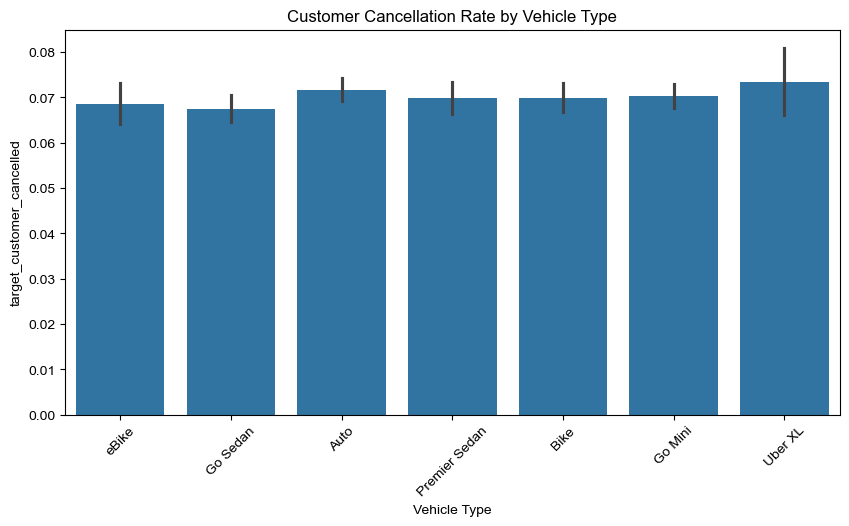

In [22]:
plt.figure(figsize=(10, 5))
sns.barplot(data=df, x='Vehicle Type', y='target_customer_cancelled')
sns.set(style="whitegrid")
plt.title("Customer Cancellation Rate by Vehicle Type")
plt.xticks(rotation=45)
plt.show()

#### 2. Cancellation Rate by Hour

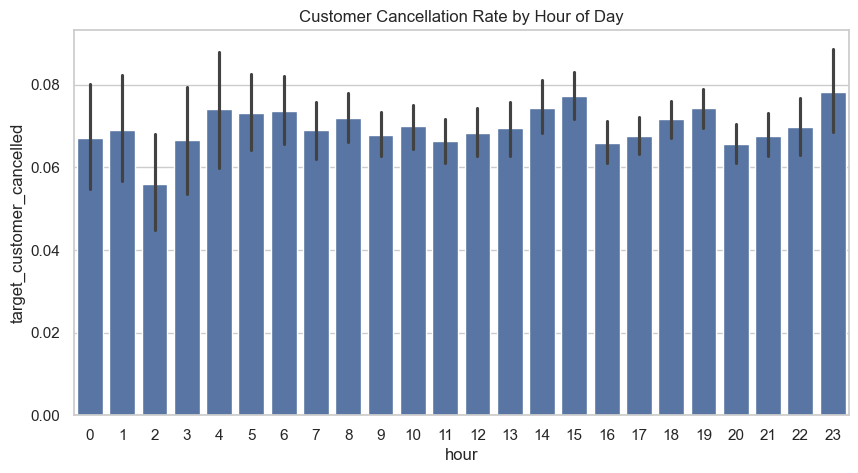

In [23]:
plt.figure(figsize=(10, 5))
sns.barplot(data=df, x='hour', y='target_customer_cancelled')
plt.title("Customer Cancellation Rate by Hour of Day")
plt.show()

####  3. Cancellation Rate by Day of Week

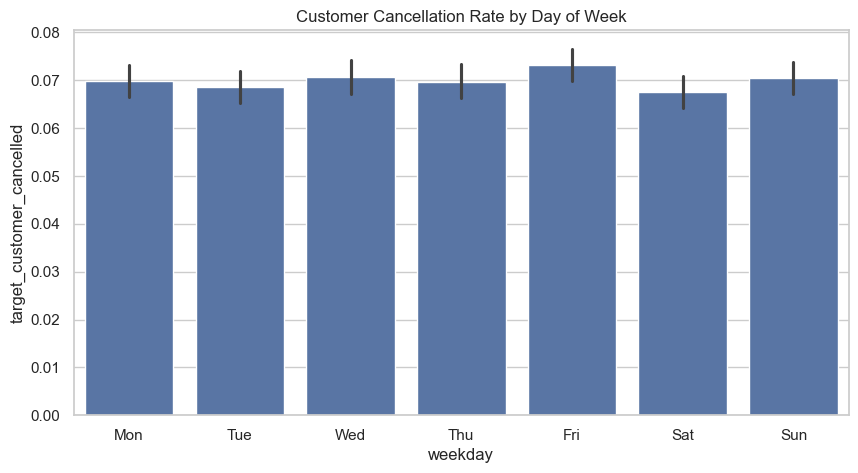

In [24]:
plt.figure(figsize=(10, 5))
sns.barplot(data=df, x='weekday', y='target_customer_cancelled')
plt.title("Customer Cancellation Rate by Day of Week")
plt.xticks(ticks=range(7), labels=["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])
plt.show()

#### 4. Driver Rating vs Cancellation

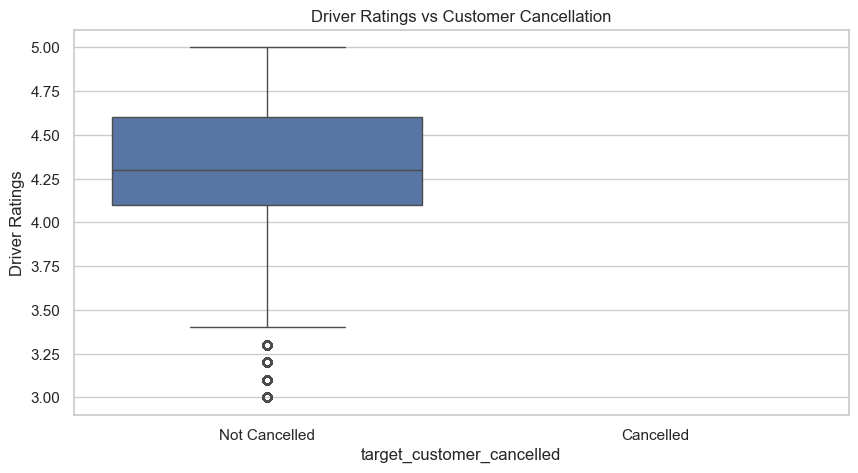

In [25]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='target_customer_cancelled', y='Driver Ratings')
plt.title("Driver Ratings vs Customer Cancellation")
plt.xticks([0, 1], ['Not Cancelled', 'Cancelled'])
plt.show()

### Location and Time EDA

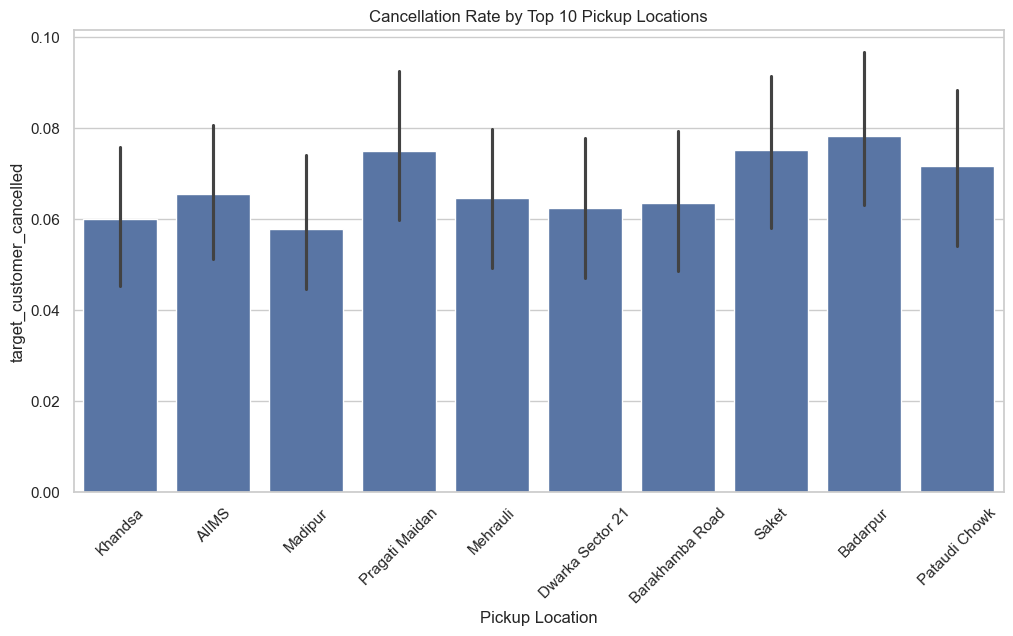

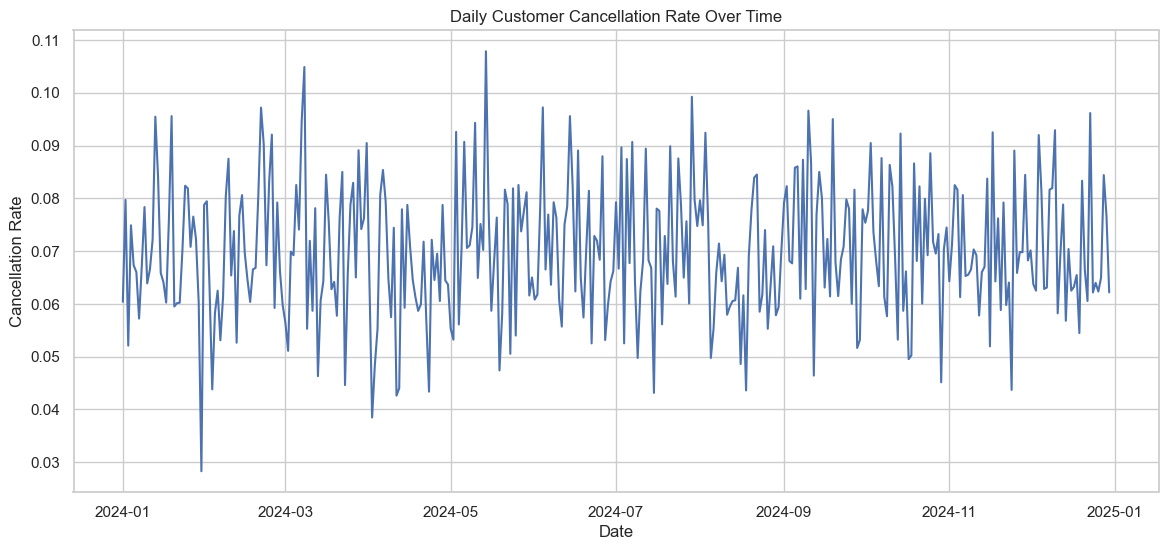

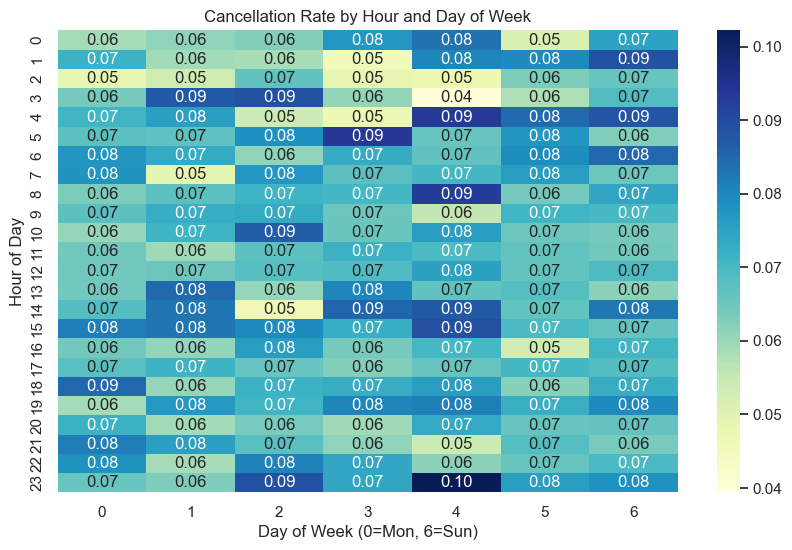

In [26]:
# 1. Top 10 Pickup Locations by Count
top_pickups = df['Pickup Location'].value_counts().nlargest(10).index
df_top_pickups = df[df['Pickup Location'].isin(top_pickups)]

plt.figure(figsize=(12, 6))
sns.barplot(data=df_top_pickups, x='Pickup Location', y='target_customer_cancelled')
plt.title("Cancellation Rate by Top 10 Pickup Locations")
plt.xticks(rotation=45)
plt.show()

# 2. Trend of Cancellations Over Time (Daily)
df_daily = df.groupby('Date')['target_customer_cancelled'].mean().reset_index()

plt.figure(figsize=(14, 6))
sns.lineplot(data=df_daily, x='Date', y='target_customer_cancelled')
plt.title("Daily Customer Cancellation Rate Over Time")
plt.ylabel("Cancellation Rate")
plt.xlabel("Date")
plt.show()

# 3. Optional: Heatmap of Hour vs Day of Week
heatmap_data = df.pivot_table(
    index='hour',
    columns='weekday',
    values='target_customer_cancelled',
    aggfunc='mean'
)

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, cmap="YlGnBu", annot=True, fmt=".2f")
plt.title("Cancellation Rate by Hour and Day of Week")
plt.ylabel("Hour of Day")
plt.xlabel("Day of Week (0=Mon, 6=Sun)")
plt.show()

### Feature Engineering

In [27]:
from sklearn.preprocessing import LabelEncoder

# 1. Vehicle Type One-Hot Encoding
df = pd.get_dummies(df, columns=['Vehicle Type'], prefix='vehicle', drop_first=True)

# 2. Encode Top 10 Pickup Locations
top_pickups = df['Pickup Location'].value_counts().nlargest(10).index
df['pickup_encoded'] = df['Pickup Location'].apply(lambda x: x if x in top_pickups else 'Other')
df = pd.get_dummies(df, columns=['pickup_encoded'], prefix='pickup', drop_first=True)

# 3. Encode Top 10 Drop Locations
top_drops = df['Drop Location'].value_counts().nlargest(10).index
df['drop_encoded'] = df['Drop Location'].apply(lambda x: x if x in top_drops else 'Other')
df = pd.get_dummies(df, columns=['drop_encoded'], prefix='drop', drop_first=True)

# 4. Customer Booking Frequency
cust_counts = df['Customer ID'].value_counts().to_dict()
df['customer_total_bookings'] = df['Customer ID'].map(cust_counts)

# 5. Replace NaNs in numeric columns with placeholder or leave as-is
# (Let tree models handle missing)
num_cols = ['Avg VTAT', 'Avg CTAT', 'Driver Ratings', 'Customer Rating']
# df[num_cols] = df[num_cols].fillna(-1)

# 6. Drop columns not needed for modeling
drop_cols = [
    'Booking ID', 'Customer ID', 'Pickup Location', 'Drop Location',
    'Cancelled Rides by Customer', 'Reason for cancelling by Customer',
    'Cancelled Rides by Driver', 'Driver Cancellation Reason',
    'Incomplete Rides', 'Incomplete Rides Reason', 'Date', 'Time', 'datetime'
]
df.drop(columns=drop_cols, inplace=True)

# 7. Final feature list
features = [col for col in df.columns if col != 'target_customer_cancelled']
target = 'target_customer_cancelled'

print(f"✅ Total Features for Modeling: {len(features)}")

✅ Total Features for Modeling: 47


### Applying Class weights 

In [28]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y=df['target_customer_cancelled']
)
weights = dict(enumerate(class_weights))
print("Class Weights:", weights)

Class Weights: {0: np.float64(0.5376344086021505), 1: np.float64(7.142857142857143)}


In [29]:
import numpy as np

# Combine X and y temporarily
temp_df = df.copy()
temp_df['target'] = df[target]

# Select only numeric columns
numeric_cols = temp_df.select_dtypes(include=[np.number]).columns

# Compute correlation with target
correlations = temp_df[numeric_cols].corr()['target'].sort_values(key=abs, ascending=False)

# Display top correlations (excluding target itself)
print("📌 Top Correlated Features with Target:\n")
print(correlations.drop('target'))

📌 Top Correlated Features with Target:

target_customer_cancelled    1.000000
Avg VTAT                     0.306592
Avg CTAT                    -0.008883
month                        0.001480
hour                         0.001475
customer_total_bookings      0.001330
day                         -0.000854
weekday                      0.000595
Booking Value                     NaN
Ride Distance                     NaN
Driver Ratings                    NaN
Customer Rating                   NaN
Name: target, dtype: float64


### Step 5: Multi Model Creation

#### Logistic Regression

In [30]:
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score

# Drop target and keep only numeric features
clean_features = df.select_dtypes(include=['number']).columns.drop('target_customer_cancelled')

# Setup X and y
X = df[clean_features]
y = df['target_customer_cancelled']

# Impute missing values
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_imputed, y, test_size=0.2, stratify=y, random_state=42
)

# Train Logistic Regression
logreg = LogisticRegression(class_weight='balanced', max_iter=1000)
logreg.fit(X_train, y_train)

# Predict
y_pred = logreg.predict(X_test)
y_prob = logreg.predict_proba(X_test)[:, 1]

# Evaluate
print("🎯 ROC AUC Score:", roc_auc_score(y_test, y_prob))
print("\n📋 Classification Report:\n", classification_report(y_test, y_pred, digits=3))

🎯 ROC AUC Score: 0.786976557433009

📋 Classification Report:
               precision    recall  f1-score   support

           0      0.966     0.733     0.834     27900
           1      0.157     0.662     0.254      2100

    accuracy                          0.728     30000
   macro avg      0.562     0.697     0.544     30000
weighted avg      0.910     0.728     0.793     30000



#### Random Forest

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.impute import SimpleImputer

# Define cleaned features
leaky_features = [
    'Avg VTAT', 'Ride Distance',
    'Booking Value', 'Customer Rating', 'Driver Ratings',
    'Booking Status', 'Payment Method',
    'missing_booking_value', 'missing_payment_method',
    'missing_driver_rating', 'missing_customer_rating',
    'is_cancelled_customer', 'is_cancelled_driver', 'is_incomplete'
]
clean_features = [f for f in features if f not in leaky_features]

# Prepare data
X = df[clean_features]
y = df['target_customer_cancelled']

# Impute missing values
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_imputed, y, test_size=0.2, stratify=y, random_state=42
)

# Train Random Forest with balanced class weights
rf = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

# Predict & Evaluate
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]

print("🎯 ROC AUC Score:", roc_auc_score(y_test, y_prob))
print("\n📋 Classification Report:\n", classification_report(y_test, y_pred, digits=3))

🎯 ROC AUC Score: 0.846262741082096

📋 Classification Report:
               precision    recall  f1-score   support

           0      0.941     0.951     0.946     27900
           1      0.237     0.200     0.217      2100

    accuracy                          0.899     30000
   macro avg      0.589     0.576     0.582     30000
weighted avg      0.891     0.899     0.895     30000



#### XGBoost 

In [45]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
import pickle

# ----------------------------
# Load the correct dataframe
# ----------------------------
df = df.copy()   # <-- use your actual main dataframe

# -----------------------------------
# Select only the 15 Streamlit features + target
# -----------------------------------

feature_cols = [
    'Avg VTAT', 'Ride Distance', 'Booking Value',
    'Customer Rating', 'Driver Ratings',
    'Booking Status', 'Payment Method',
    'missing_booking_value', 'missing_payment_method',
    'missing_driver_rating', 'missing_customer_rating',
    'is_cancelled_customer', 'is_cancelled_driver', 'is_incomplete',
    'hour'
]

target = "target_customer_cancelled"   # modify if needed

df_small = df[feature_cols + [target]].copy()

# ----------------------------
# Fill missing numeric values
# ----------------------------
for col in ['Booking Value', 'Customer Rating', 'Driver Ratings']:
    df_small[col] = df_small[col].fillna(0)

# ----------------------------
# Label Encode the categorical columns
# ----------------------------
le_status = LabelEncoder()
df_small['Booking Status'] = le_status.fit_transform(df_small['Booking Status'])

le_pay = LabelEncoder()
df_small['Payment Method'] = le_pay.fit_transform(df_small['Payment Method'])

# ----------------------------
# Split the data
# ----------------------------
X = df_small[feature_cols]
y = df_small[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ----------------------------
# Train XGBoost
# ----------------------------
model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    eval_metric="logloss"
)

model.fit(X_train, y_train)

# ----------------------------
# Evaluate
# ----------------------------
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

# ----------------------------
# Save model as PKL
# ----------------------------
with open("urc_model.pkl", "wb") as f:
    pickle.dump(model, f)

print("Model saved successfully!")


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     27923
           1       1.00      1.00      1.00      2077

    accuracy                           1.00     30000
   macro avg       1.00      1.00      1.00     30000
weighted avg       1.00      1.00      1.00     30000

Model saved successfully!


### 📊 Final Comparison

In [33]:
all_model_score  = [logreg,rf,xgb_model]
model_name = ['Logistic','Random Forest','XGB']
print('Done')

Done


In [34]:
logreg_score = 0.786976557433009
rf_score = 0.8462628349547705
xgb_score = 0.8645445041816009

In [35]:
all_model_score = [logreg_score, rf_score, xgb_score]
model_name = ['Logistic Regression', 'Random Forest', 'XGBoost']

Best Model: XGBoost


<Figure size 1000x500 with 0 Axes>

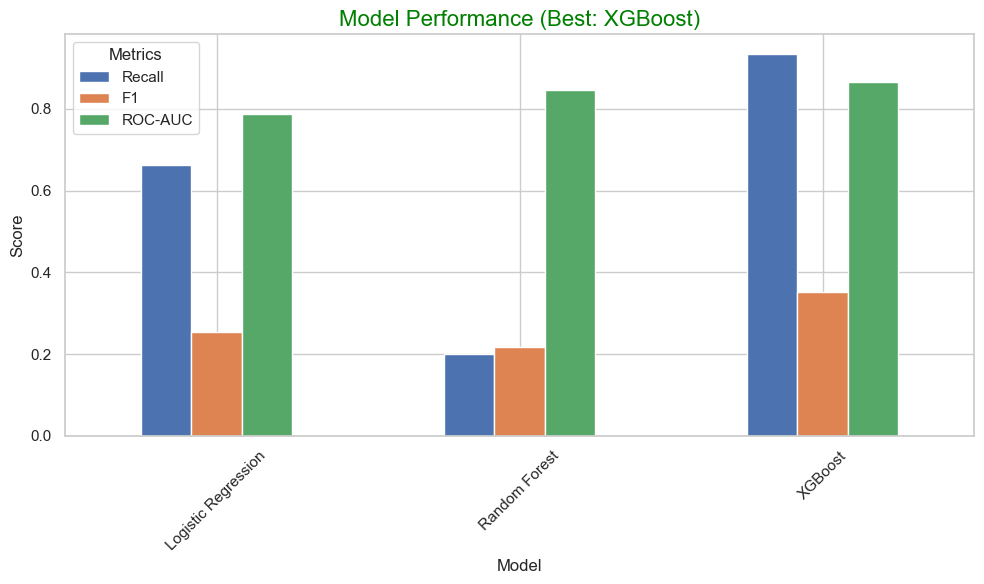

In [36]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt


# Your current model scores
data = {
    "Model": ["Logistic Regression", "Random Forest", "XGBoost"],
    "Recall": [0.662, 0.200, 0.935],
    "F1": [0.254, 0.217, 0.353],
    "ROC-AUC": [0.7869, 0.8462, 0.8645]
}

# Convert to DataFrame
results_df = pd.DataFrame(data).set_index("Model")

# Determine best model based on Recall > F1 > ROC-AUC priority
best_model_name = results_df.sort_values(
    by=["Recall", "F1", "ROC-AUC"],
    ascending=False
).index[0]

print("Best Model:", best_model_name)

# Plot using matplotlib only
plt.figure(figsize=(10,5))
results_df.plot(kind="bar", figsize=(10,6))
plt.title(f"Model Performance (Best: {best_model_name})", fontsize=16, color="green")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend(title="Metrics")
plt.tight_layout()
plt.show()
